In [1]:
import os
import sys
sys.path.append('../')
import curvedsky as cs
import healpy as hp
import matplotlib.pyplot as plt
from utils import camb_clfile,cli
import numpy as np
import cmb

In [ ]:
infolder = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/'
dnside = 512
lmax = 3*dnside -1
maskpath = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits'
fwhm = 30
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]

In [ ]:
mask = hp.ud_grade(hp.read_map(maskpath),dnside)

In [23]:
def get_cmb(idx):
    fname = os.path.join(infolder,f"cmb_sims_{idx:04d}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_noise_spectra(depth_i,depth_p):
    t = np.ones(lmax+1)*(np.radians(depth_i/60)**2)
    e = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    b = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    return t,e,b

def get_noise_alm(depth_i,depth_p):
    t,e,b = get_noise_spectra(depth_i,depth_p)
    t = hp.synalm(t,lmax=lmax)
    e = hp.synalm(e,lmax=lmax)
    b = hp.synalm(b,lmax=lmax)
    return t,e,b

def get_noise_map(depth_i,depth_p):
    t,e,b = get_noise_spectra(depth_i,depth_p)
    return hp.alm2map([t,e,b],nside=dnside)



In [ ]:
sigma = 2.16
Tcmb  = 2.726e6
beam = hp.gauss_beam(np.radians(fwhm/30),lmax=lmax)
Bl = np.reshape(beam,(1,lmax+1))
invn = mask * (np.radians(sigma/60)/Tcmb)**-2
invN = np.reshape(np.array((invn,invn)),(2,1,hp.nside2npix(dnside)))

In [6]:
T,Q,U = (hp.smoothing(get_cmb(0),fwhm=np.radians(fwhm/60)) + get_noise_map(1.5,sigma))*mask

In [7]:
tlm, elm, blm = hp.map2alm([T,Q,U])

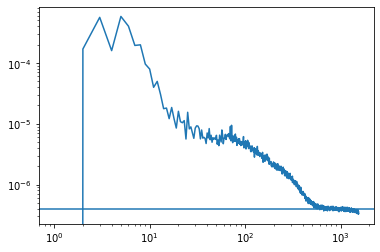

In [8]:
plt.loglog(hp.alm2cl(blm)/.8)
plt.axhline(np.radians(sigma/60)**2)

In [9]:
QU1 = np.reshape(np.array((Q,U)),(2,1,hp.nside2npix(dnside)))/Tcmb

In [10]:
E1,B1 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

In [24]:
nt,ne,nb = get_noise_spectra(1.5,2.16)
NL = np.reshape(np.array((cli(ne[:lmax+1]/Tcmb**2),cli(nb[:lmax+1]/Tcmb**2))),(2,1,lmax+1))
E2,B2 = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],
                Bl,np.reshape(np.array((mask,mask)),(2,1,hp.nside2npix(dnside))),QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,inl=NL,stat='statues.txt')

/tmp/ipykernel_29032/3285455856.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(1000000000, 2.3380833647926993e+22)

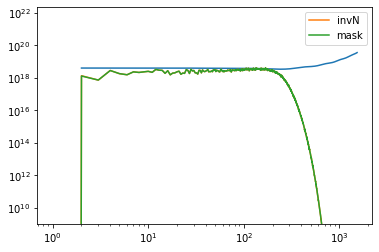

In [25]:
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B1),label='invN')
plt.loglog(cs.utils.alm2cl(lmax,B2),label='mask')
plt.legend()
plt.ylim(10**9,None)